# Baseline MIA Evaluation

In [42]:
import os
import torch
from torch import nn
import torchinfo
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2 as cv
from tqdm.notebook import tqdm
# from pycocotools.coco import COCO

# scripts
from training import get_transform_list, get_dataset, CombinedDataset, Subset, get_distilgpt2_srn18_vae, seed_torch

os.environ["CUDA_VISIBLE_DEVICES"] = '0'


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using', device)

using cuda


In [3]:
SEED = 13
DATA_DIR = "data/mscoco"

transform_list = get_transform_list()

# get datasets
train_ds = get_dataset(transform_list, dataset_type="train2014", data_dir=DATA_DIR, seed=SEED)
val_ds = get_dataset(transform_list, dataset_type="val2014", data_dir=DATA_DIR, seed=SEED)
test_ds = get_dataset(transform_list, dataset_type="test2014", data_dir=DATA_DIR, seed=SEED)


loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [4]:
print('train:\t', len(train_ds))
print('val:\t', len(val_ds))
print('test:\t', len(test_ds))

train:	 82783
val:	 40504
test:	 40775


In [5]:
random_gen = random.Random(SEED)

# Generate random indices
n_subset = 5_000
train_idxs = random_gen.sample(range(len(train_ds)), n_subset)
test_idxs = random_gen.sample(range(len(test_ds)), n_subset)

# sample subsets
train_subset = Subset(train_ds, train_idxs)
test_subset = Subset(test_ds, test_idxs)

mia_ds = CombinedDataset(train_subset, test_subset, 1, 0)
len(mia_ds)

10000

In [6]:
param_dict = {
	'captioner_weights': "logs/tests/srn18_vae_dgpt2_z3/best.pth",
	'mixed_precision': 1,
    'freeze_encoder': 0, # only affects things if ur finetuning the model
}
model = get_distilgpt2_srn18_vae(param_dict)
model.eval()
model = model.to(device)

loading captioner weights from: logs/tests/srn18_vae_dgpt2_z3/best.pth


In [7]:
# def cosine_sim_attack(image, caption):
    

#     cos_sim = torch.nn.functional.cosine_similarity(image_arr, pad_cap_arr, dim=0)
#     print(f"{cos_sim = }")
#     # print(f"{pad_cap_arr[:14] = }")


# def perform_attack(attack_func, model, dataset):
#     # score_list = []
#     # idx_list = []
#     # truth_list = []

#     result_list = []
#     for item_dict in tqdm(dataset):
#         image = item_dict['image']

#         # generate a caption with the model and use it to perform the attack
#         out_dict = model.generate_caption(image)
#         result_list.append(
#             {**item_dict, **out_dict}
#         )
        
#     return result_list
    
#         # print(mia_score)
#         # break
#         # update lists
#         # score_list.append(score_list)
#         # mia_score = attack_func(image, out_dict['ids'])

In [8]:
mia_generated_captions = model.generate_batch_captions(mia_ds, max_workers=32)

started generation supervisor...


main:   0%|          | 0/10000 [00:00<?, ?it/s]

[w:   0] [i: ?] |            | , status=starting up

[w:   1] [i: ?] |            | , status=starting up

[w:   2] [i: ?] |            | , status=starting up

[w:   3] [i: ?] |            | , status=starting up

[w:   4] [i: ?] |            | , status=starting up

[w:   5] [i: ?] |            | , status=starting up

[w:   6] [i: ?] |            | , status=starting up

[w:   7] [i: ?] |            | , status=starting up

[w:   8] [i: ?] |            | , status=starting up

[w:   9] [i: ?] |            | , status=starting up

[w:  10] [i: ?] |            | , status=starting up

[w:  11] [i: ?] |            | , status=starting up

[w:  12] [i: ?] |            | , status=starting up

[w:  13] [i: ?] |            | , status=starting up

[w:  14] [i: ?] |            | , status=starting up

[w:  15] [i: ?] |            | , status=starting up

[w:  16] [i: ?] |            | , status=starting up

[w:  17] [i: ?] |            | , status=starting up

[w:  18] [i: ?] |            | , status=starting up

[w:  19] [i: ?] |            | , status=starting up

[w:  20] [i: ?] |            | , status=starting up

[w:  21] [i: ?] |            | , status=starting up

[w:  22] [i: ?] |            | , status=starting up

[w:  23] [i: ?] |            | , status=starting up

[w:  24] [i: ?] |            | , status=starting up

[w:  25] [i: ?] |            | , status=starting up

[w:  26] [i: ?] |            | , status=starting up

[w:  27] [i: ?] |            | , status=starting up

[w:  28] [i: ?] |            | , status=starting up

[w:  29] [i: ?] |            | , status=starting up

[w:  30] [i: ?] |            | , status=starting up

[w:  31] [i: ?] |            | , status=starting up

In [9]:
import pickle

pickle_file_path = "baseline_mia10k.pickle"

with open(pickle_file_path, 'wb') as handle:
    pickle.dump(mia_generated_captions, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(pickle_file_path, 'rb') as handle:
#     mia_loaded_captions = pickle.load(handle)

In [11]:
len(mia_generated_captions)

10000

In [32]:
from scipy.spatial.distance import cosine, euclidean
import pandas as pd
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:

def standardize_dims(img_list: list, caption_list: list):
    n = len(img_list)
    img_arr = np.array(img_list).reshape(n, -1)
    
    pad_cap_arr = np.zeros_like(img_arr, dtype=int)
    for i, caption in enumerate(caption_list):
        # trim bos/eos tokens
        caption = caption[1:-1]
        pad_cap_arr[i, :len(caption)] = caption
        
    return img_arr, pad_cap_arr

def reduce_feature(X, n: int = 2):
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X)
    return X_reduced

def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.5, .2, label, fontweight="bold", color=color,
            ha="left", transform=ax.transAxes, fontsize=18)

def kde_w_conf(x, color, label, **kwargs):
    ax = plt.gca()

    mean, std = np.mean(x), np.std(x)
    
    # Kernel density estimation (KDE) for smoother curves
    kde = sns.kdeplot(x, color=color, ax=ax, **kwargs)
    # kde_line = kde.get_lines()[-1]
    # kde_x, kde_y = kde_line.get_data()

    ax.text(-0.15, 0.2, f"x̄: {mean:.2f}\ns: {std:.2f}", fontweight="bold", color=color,
            ha="left", transform=ax.transAxes, fontsize=12)






In [44]:

def plot_roc_mia(scores, truths, mia_type: str):
    # get tpr and fpr for roc
    fpr, tpr, _ = roc_curve(truths, scores)
    mia_auroc = auc(fpr, tpr)

    # since our scores are directionless we may need to flip them
    if mia_auroc < 0.5:
        # get tpr and fpr for roc
        fpr, tpr, _ = roc_curve(truths, [-s for s in scores])
        mia_auroc = auc(fpr, tpr)
    
    # plot roc
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC: {mia_auroc:.2f})')
    plt.plot([0, 1], [0, 1], color='lightblue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {mia_type} MIA')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, mia_auroc

def plot_stacked_roc(roc_dict_list: list, mia_type: str):
    # initialize plot
    plt.figure()
    plt.plot([0, 1], [0, 1], color='lightblue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Stacked ROC Plot for {mia_type} MIA')
    
    for roc_dict in roc_dict_list:
        plt.plot(roc_dict['fpr'], roc_dict['tpr'], lw=2, label=f"{roc_dict['model_name']} (AUC: {roc_dict['auroc']:.2f})")

    plt.legend(loc="lower right")
    plt.show()

def get_tpr_fpr_dict(tpr, fpr, fpr_list=None):
    if fpr_list is None:
        fpr_list = [0.001, 0.01, 0.1]

    # get the tpr at the target fpr values
    tpr_fpr_dict = {}
    for target_fpr in fpr_list:
        # get the idx of the first fpr that exceeds the target
        idx = np.argmax(fpr >= target_fpr)
        
        # get the tpr and actual fpr at the idx
        actual_tpr = tpr[idx]
        actual_fpr = fpr[idx]
        
        tpr_fpr_dict[target_fpr] = (actual_tpr, actual_fpr)
    
    return tpr_fpr_dict

# 1. Distance-Based MIA

## 1.1 Raw Inputs/Outputs

In [20]:
mia_list = []

for caption_dict in tqdm(mia_generated_captions):
    ds_idx = caption_dict['idx']
    ds_dict = mia_ds[ds_idx]

    mia_list.append({
        "idx": ds_idx,
        "token_ids": caption_dict['ids'],
        "tokens": caption_dict['tokens'],
        "image": ds_dict['image'],
        "label": ds_dict['label'].item(),
    })

  0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
result_list = mia_list.copy()

In [30]:
img_list = [i['image'].numpy() for i in result_list]
id_list = [i['token_ids'] for i in result_list]
label_list = [i['label'] for i in result_list]

img_arr, id_arr = standardize_dims(img_list, id_list)

cosine_list = [cosine(i_arr, c_arr) for i_arr, c_arr in zip(img_arr, id_arr)]
euclid_list = [euclidean(i_arr, c_arr) for i_arr, c_arr in zip(img_arr, id_arr)]
member_list = ['member' if l == 1 else 'non-member' for l in label_list]

cos_df = pd.DataFrame({'cosine_similarity': cosine_list, 'label': member_list})
euc_df = pd.DataFrame({'euclidean_distance': euclid_list, 'label': member_list})

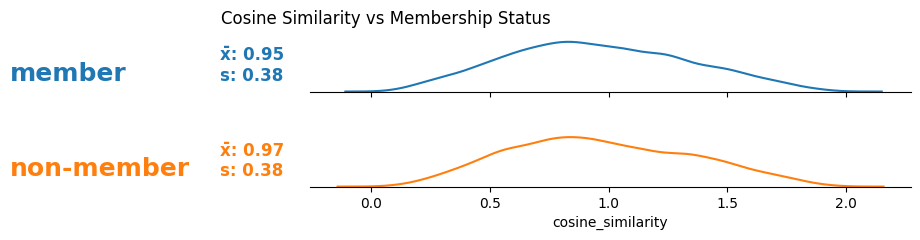

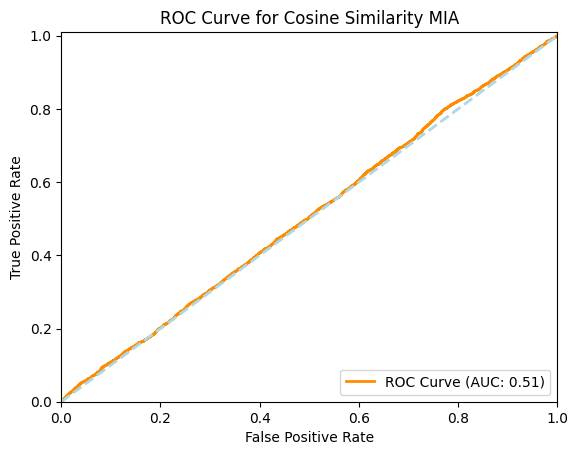

auroc: 0.507
tpr: 0.000 @ fpr: 0.001
tpr: 0.015 @ fpr: 0.010
tpr: 0.108 @ fpr: 0.100





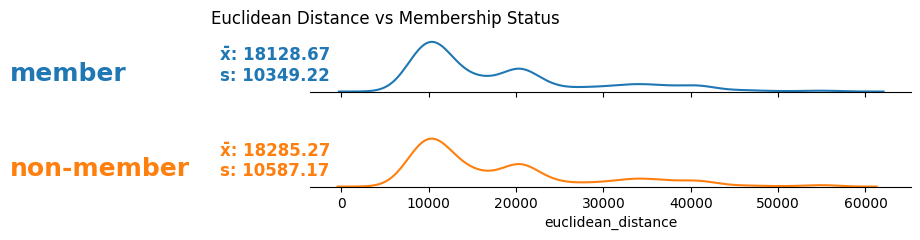

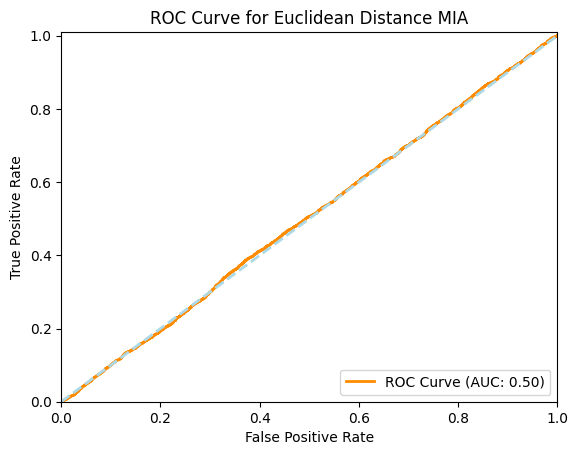

auroc: 0.502
tpr: 0.000 @ fpr: 0.001
tpr: 0.007 @ fpr: 0.010
tpr: 0.100 @ fpr: 0.100





In [48]:
for metric, df in zip(["cosine_similarity", "euclidean_distance"], [cos_df, euc_df]):
    g = sns.FacetGrid(df, row='label', hue='label', aspect=9, height=1.2)
    g.map(kde_w_conf, metric)
    g.map(label, metric)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=False, left=True)
    
    plt.suptitle(f"{metric.replace('_', ' ').title()} vs Membership Status")
    plt.show()

    fpr, tpr, mia_auroc = plot_roc_mia(
        df[metric].tolist(), 
        label_list, 
        metric.replace('_', ' ').title()
    )
    tpr_fpr_dict = get_tpr_fpr_dict(tpr, fpr)
    print(f"auroc: {mia_auroc:.3f}")
    for k, v in tpr_fpr_dict.items():
        print(f"tpr: {v[0]:.3f} @ fpr: {v[1]:.3f}")
    print("\n\n")
        

## 1.2 PCA (n:2)

In [59]:
img_pca_arr = reduce_feature(img_arr, n=2)
id_pca_arr = reduce_feature(id_arr, n=2)

cosine_list = [cosine(img_pca, cap_pca) for img_pca, cap_pca in zip(img_pca_arr, id_pca_arr)]
euclid_list = [euclidean(img_pca, cap_pca) for img_pca, cap_pca in zip(img_pca_arr, id_pca_arr)]
member_list = ['member' if l == 1 else 'non-member' for l in label_list]

cos_df = pd.DataFrame({'cosine_similarity': cosine_list, 'label': ['member' if l == 1 else 'non-member' for l in label_list]})
euc_df = pd.DataFrame({'euclidean_distance': euclid_list, 'label': ['member' if l == 1 else 'non-member' for l in label_list]})

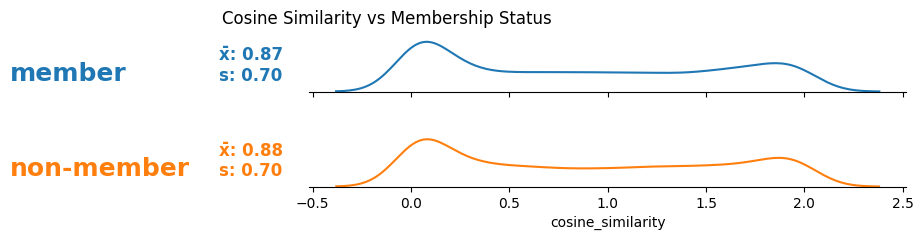

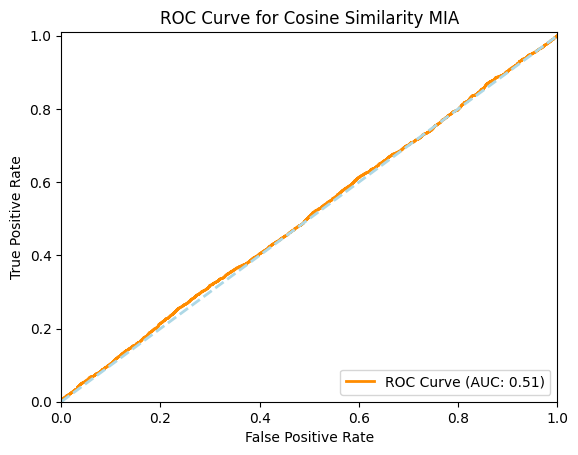

auroc: 0.506
tpr: 0.003 @ fpr: 0.001
tpr: 0.015 @ fpr: 0.010
tpr: 0.104 @ fpr: 0.100





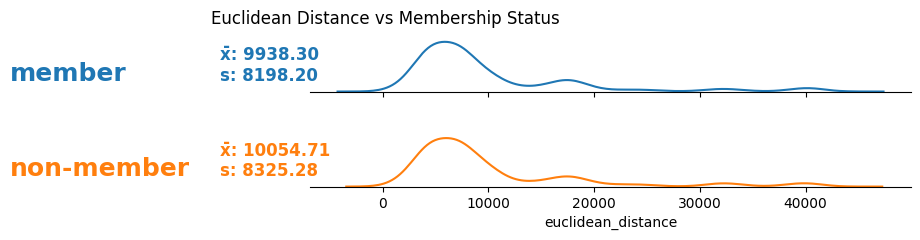

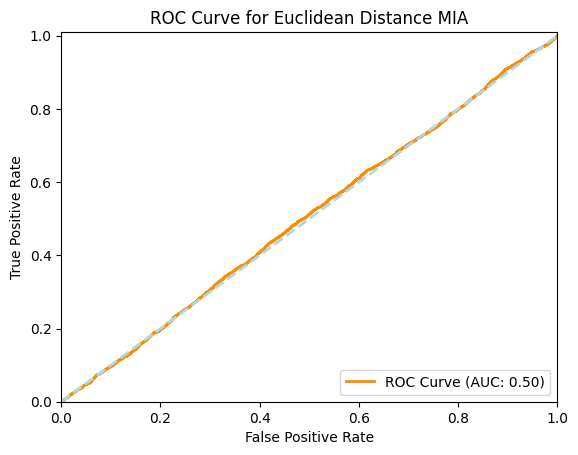

auroc: 0.504
tpr: 0.002 @ fpr: 0.002
tpr: 0.009 @ fpr: 0.010
tpr: 0.096 @ fpr: 0.100





In [60]:
for metric, df in zip(["cosine_similarity", "euclidean_distance"], [cos_df, euc_df]):
    g = sns.FacetGrid(df, row='label', hue='label', aspect=9, height=1.2)
    g.map(kde_w_conf, metric)
    g.map(label, metric)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=False, left=True)
    
    plt.suptitle(f"{metric.replace('_', ' ').title()} vs Membership Status")
    plt.show()

    fpr, tpr, mia_auroc = plot_roc_mia(
        df[metric].tolist(), 
        label_list, 
        metric.replace('_', ' ').title()
    )
    tpr_fpr_dict = get_tpr_fpr_dict(tpr, fpr)
    print(f"auroc: {mia_auroc:.3f}")
    for k, v in tpr_fpr_dict.items():
        print(f"tpr: {v[0]:.3f} @ fpr: {v[1]:.3f}")
    print("\n\n")
        

## 1.3 PCA (n:4)

In [61]:
img_pca_arr = reduce_feature(img_arr, n=4)
id_pca_arr = reduce_feature(id_arr, n=4)

cosine_list = [cosine(img_pca, cap_pca) for img_pca, cap_pca in zip(img_pca_arr, id_pca_arr)]
euclid_list = [euclidean(img_pca, cap_pca) for img_pca, cap_pca in zip(img_pca_arr, id_pca_arr)]
member_list = ['member' if l == 1 else 'non-member' for l in label_list]

cos_df = pd.DataFrame({'cosine_similarity': cosine_list, 'label': ['member' if l == 1 else 'non-member' for l in label_list]})
euc_df = pd.DataFrame({'euclidean_distance': euclid_list, 'label': ['member' if l == 1 else 'non-member' for l in label_list]})

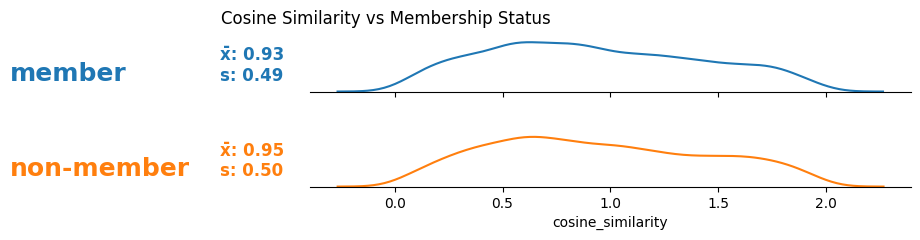

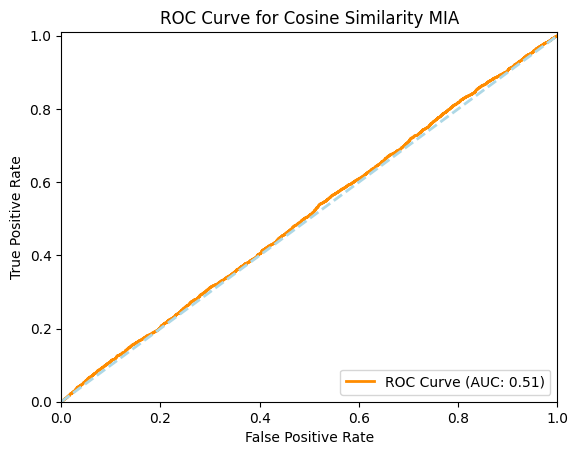

auroc: 0.509
tpr: 0.001 @ fpr: 0.001
tpr: 0.010 @ fpr: 0.010
tpr: 0.110 @ fpr: 0.100





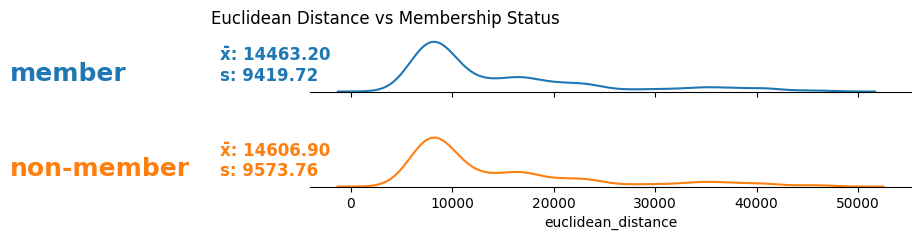

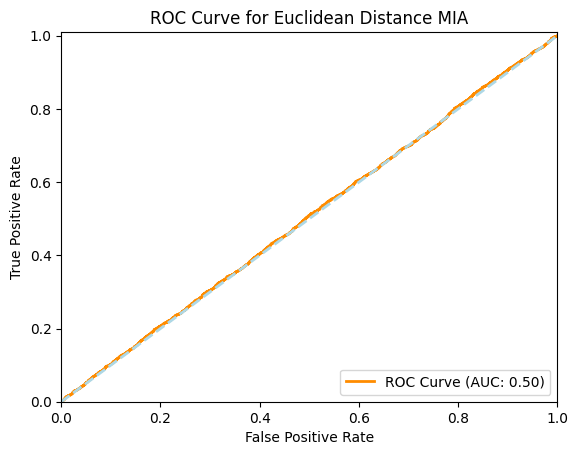

auroc: 0.503
tpr: 0.002 @ fpr: 0.001
tpr: 0.013 @ fpr: 0.010
tpr: 0.102 @ fpr: 0.100





In [62]:
for metric, df in zip(["cosine_similarity", "euclidean_distance"], [cos_df, euc_df]):
    g = sns.FacetGrid(df, row='label', hue='label', aspect=9, height=1.2)
    g.map(kde_w_conf, metric)
    g.map(label, metric)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=False, left=True)
    
    plt.suptitle(f"{metric.replace('_', ' ').title()} vs Membership Status")
    plt.show()

    fpr, tpr, mia_auroc = plot_roc_mia(
        df[metric].tolist(), 
        label_list, 
        metric.replace('_', ' ').title()
    )
    tpr_fpr_dict = get_tpr_fpr_dict(tpr, fpr)
    print(f"auroc: {mia_auroc:.3f}")
    for k, v in tpr_fpr_dict.items():
        print(f"tpr: {v[0]:.3f} @ fpr: {v[1]:.3f}")
    print("\n\n")
        

## 1.4 PCA (n:6)

In [63]:
img_pca_arr = reduce_feature(img_arr, n=6)
id_pca_arr = reduce_feature(id_arr, n=6)

cosine_list = [cosine(img_pca, cap_pca) for img_pca, cap_pca in zip(img_pca_arr, id_pca_arr)]
euclid_list = [euclidean(img_pca, cap_pca) for img_pca, cap_pca in zip(img_pca_arr, id_pca_arr)]
member_list = ['member' if l == 1 else 'non-member' for l in label_list]

cos_df = pd.DataFrame({'cosine_similarity': cosine_list, 'label': ['member' if l == 1 else 'non-member' for l in label_list]})
euc_df = pd.DataFrame({'euclidean_distance': euclid_list, 'label': ['member' if l == 1 else 'non-member' for l in label_list]})

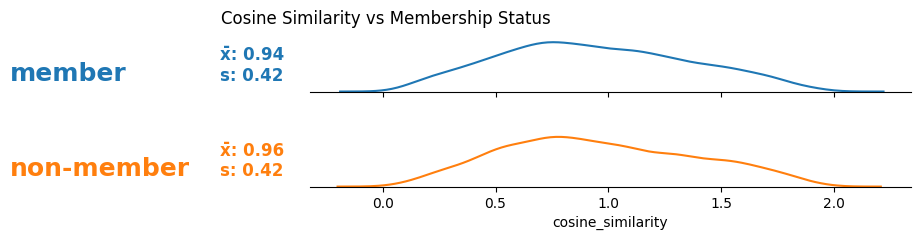

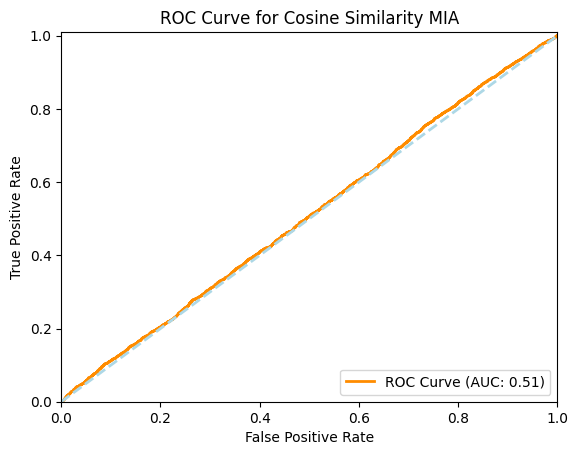

auroc: 0.509
tpr: 0.001 @ fpr: 0.001
tpr: 0.013 @ fpr: 0.010
tpr: 0.112 @ fpr: 0.100





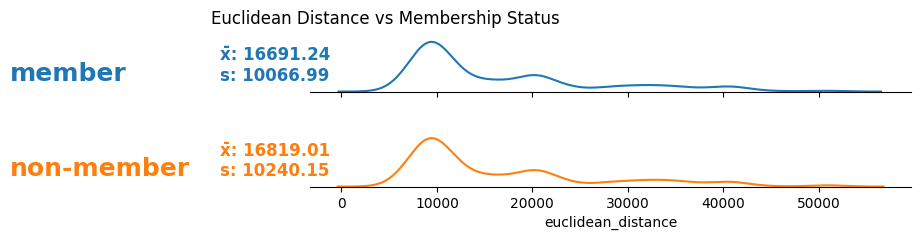

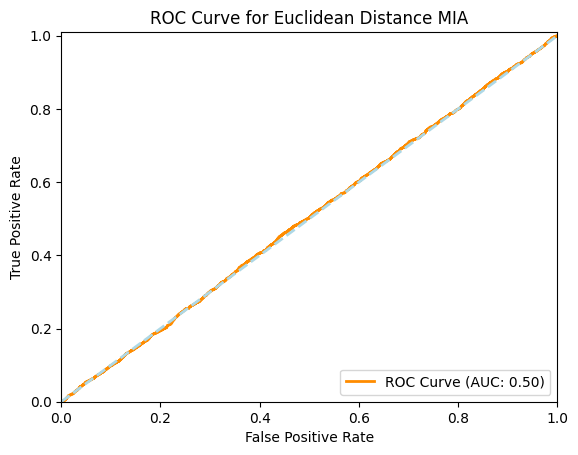

auroc: 0.502
tpr: 0.000 @ fpr: 0.001
tpr: 0.007 @ fpr: 0.010
tpr: 0.099 @ fpr: 0.100





In [64]:
for metric, df in zip(["cosine_similarity", "euclidean_distance"], [cos_df, euc_df]):
    g = sns.FacetGrid(df, row='label', hue='label', aspect=9, height=1.2)
    g.map(kde_w_conf, metric)
    g.map(label, metric)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=False, left=True)
    
    plt.suptitle(f"{metric.replace('_', ' ').title()} vs Membership Status")
    plt.show()

    fpr, tpr, mia_auroc = plot_roc_mia(
        df[metric].tolist(), 
        label_list, 
        metric.replace('_', ' ').title()
    )
    tpr_fpr_dict = get_tpr_fpr_dict(tpr, fpr)
    print(f"auroc: {mia_auroc:.3f}")
    for k, v in tpr_fpr_dict.items():
        print(f"tpr: {v[0]:.3f} @ fpr: {v[1]:.3f}")
    print("\n\n")
        

## 1.5 PCA (n:8)

In [65]:
img_pca_arr = reduce_feature(img_arr, n=8)
id_pca_arr = reduce_feature(id_arr, n=8)

cosine_list = [cosine(img_pca, cap_pca) for img_pca, cap_pca in zip(img_pca_arr, id_pca_arr)]
euclid_list = [euclidean(img_pca, cap_pca) for img_pca, cap_pca in zip(img_pca_arr, id_pca_arr)]
member_list = ['member' if l == 1 else 'non-member' for l in label_list]

cos_df = pd.DataFrame({'cosine_similarity': cosine_list, 'label': ['member' if l == 1 else 'non-member' for l in label_list]})
euc_df = pd.DataFrame({'euclidean_distance': euclid_list, 'label': ['member' if l == 1 else 'non-member' for l in label_list]})

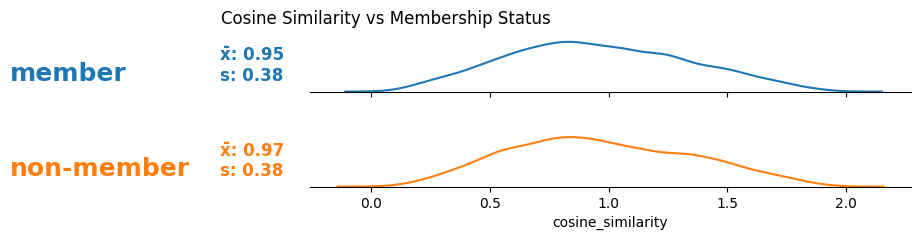

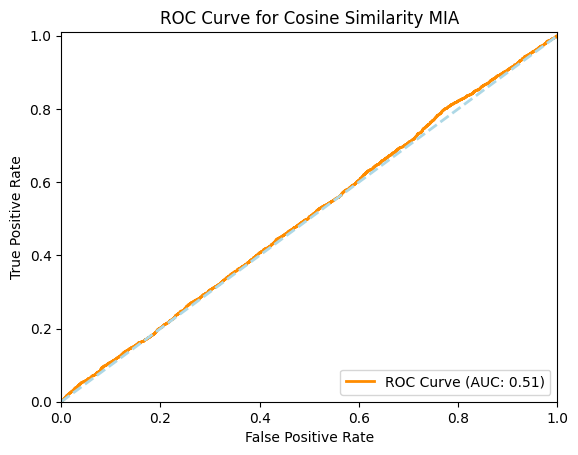

auroc: 0.507
tpr: 0.000 @ fpr: 0.001
tpr: 0.015 @ fpr: 0.010
tpr: 0.108 @ fpr: 0.100





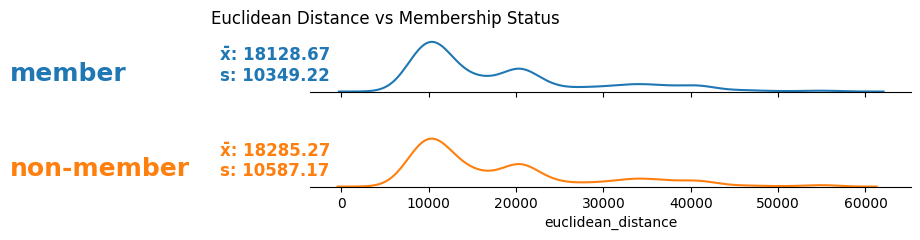

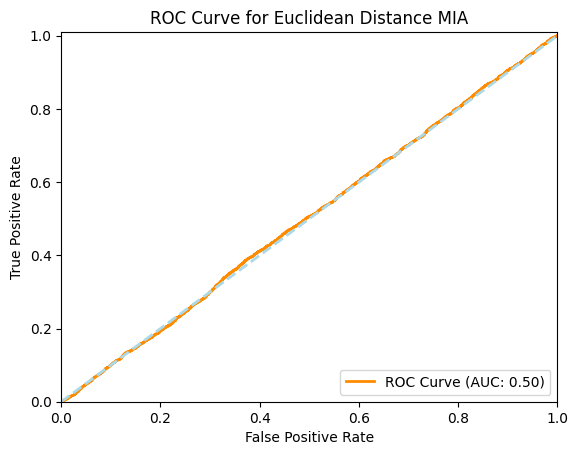

auroc: 0.502
tpr: 0.000 @ fpr: 0.001
tpr: 0.007 @ fpr: 0.010
tpr: 0.100 @ fpr: 0.100





In [66]:
for metric, df in zip(["cosine_similarity", "euclidean_distance"], [cos_df, euc_df]):
    g = sns.FacetGrid(df, row='label', hue='label', aspect=9, height=1.2)
    g.map(kde_w_conf, metric)
    g.map(label, metric)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=False, left=True)
    
    plt.suptitle(f"{metric.replace('_', ' ').title()} vs Membership Status")
    plt.show()

    fpr, tpr, mia_auroc = plot_roc_mia(
        df[metric].tolist(), 
        label_list, 
        metric.replace('_', ' ').title()
    )
    tpr_fpr_dict = get_tpr_fpr_dict(tpr, fpr)
    print(f"auroc: {mia_auroc:.3f}")
    for k, v in tpr_fpr_dict.items():
        print(f"tpr: {v[0]:.3f} @ fpr: {v[1]:.3f}")
    print("\n\n")
        